In [104]:
import pandas as pd
import numpy as np
import time
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from scipy import sparse
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cd '/Users/Mengying/Desktop/Networks/Project'

/Users/Mengying/Desktop/Networks/Project


In [4]:
# read in user taste profile data
profile = pd.read_table('Data/train_triplets.txt', names = ['user','song','count'])
profile.head() # 48,373,586

,user,song,count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


In [5]:
unique_users = profile.groupby(['user'])['count'].sum()
unique_users.head() #1,019,318, close to 1M users' listening history

user
00000b722001882066dff9d2da8a775658053ea0    13
00001638d6189236866af9bbf309ae6c2347ffdc    56
0000175652312d12576d9e6b84f600caa24c4715    19
00001cf0dce3fb22b0df0f3a1d9cd21e38385372    25
0000267bde1b3a70ea75cf2b2d216cb828e3202b    27
Name: count, dtype: int64

In [6]:
unique_users.sort_values(ascending=False, inplace = True)
unique_users.tail() # the least number of times users have listened to in total: 10

user
0155cff3544ca02cc471d0d4ce1148c7f000ae7e    10
c35b8664d4dc68308e91934e1cdc28d34bee86f6    10
467ea4cb5fa300b650fa6b27b80495b4315db3bb    10
46842492af4e0c8aa6c5d6cb3ea6982873dea4e2    10
98b8b7dd46b150d5181f5674c0f8f686066f3b4e    10
Name: count, dtype: int64

In [195]:
## Unique songs
unique_songs = pd.unique(profile['song'])
unique_songs = pd.DataFrame(unique_songs, columns=['song_id'])
unique_songs.head() #384,546 songs

,song_id
0,SOAKIMP12A8C130995
1,SOAPDEY12A81C210A9
2,SOBBMDR12A8C13253B
3,SOBFNSP12AF72A0E22
4,SOBFOVM12A58A7D494


In [138]:
# https://labrosa.ee.columbia.edu/millionsong/sites/default/files/AdditionalFiles/unique_tracks.txt
unique_tracks_full = pd.read_csv('/Users/Mengying/Desktop/Networks/Project/MSD/Data_userprofile/unique_tracks_full.txt',names = ['track_id','song_id','artist','song'],sep='<SEP>',engine='python')
unique_tracks_full.head()

,track_id,song_id,artist,song
0,TRMMMYQ128F932D901,SOQMMHC12AB0180CB8,Faster Pussy cat,Silent Night
1,TRMMMKD128F425225D,SOVFVAK12A8C1350D9,Karkkiautomaatti,Tanssi vaan
2,TRMMMRX128F93187D9,SOGTUKN12AB017F4F1,Hudson Mohawke,No One Could Ever
3,TRMMMCH128F425532C,SOBNYVR12A8C13558C,Yerba Brava,Si Vos Querés
4,TRMMMWA128F426B589,SOHSBXH12A8C13B0DF,Der Mystic,Tangle Of Aspens


In [197]:
full_profile = profile.merge(unique_tracks_full, left_on='song', right_on='song_id', how='left')
len(full_profile) #48,373,586 --> # 49,664,528 because some songs have 2-3 different track ids.

49664528

In [198]:
full_profile.drop(['song_x'],inplace=True, axis=1)
full_profile.head(11)

,user,count,track_id,song_id,artist,song_y
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,TRIQAUQ128F42435AD,SOAKIMP12A8C130995,Jack Johnson,The Cove
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,TRIRLYL128F42539D1,SOAPDEY12A81C210A9,Billy Preston,Nothing from Nothing
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,2,TRMHBXZ128F4238406,SOBBMDR12A8C13253B,Paco De Lucia,Entre Dos Aguas
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,TRYQMNI128F147C1C7,SOBFNSP12AF72A0E22,Josh Rouse,Under Cold Blue Stars
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,TRAHZNE128F9341B86,SOBFOVM12A58A7D494,The Dead 60s,Riot Radio (Soundtrack Version)
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,TRJPXGD128F92F17D7,SOBNZDC12A6D4FC103,Amset,Sin límites (I)
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,2,TRPLAXZ128F4292406,SOBSUJE12A6D4F8CF5,Jorge Drexler,12 segundos de oscuridad
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,TREGAVI128F147C1CA,SOBVFZR12A6D4F8AE3,Josh Rouse,Ears To The Ground (Album Version)
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,TRZYZWL128F4277AD2,SOBXALG12A8C13C108,Eric Hutchinson,Food Chain (Album Version)
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,TRHNCIR128F42334A5,SOBXHDL12A81C204C0,Kanye West,Stronger


In [177]:
# check for distribution for duplicated mapping
check = full_profile.groupby(['song_id'])['track_id'].nunique()
len(check[check.values >= 3]) # 632 for 1 song maps to 2 track_ids, 39 for 1 song maps to 3 track_ids. Not so many

39

In [199]:
# Indeed, we see close to 1M records duplicated, one song maps to multiple track_ids.
full_profile['is_dup'] = full_profile.duplicated(['user','song_id','artist','song_y'])
len(full_profile[full_profile.is_dup == True]) # 1,115,522

1115522

In [184]:
# Example of duplicates. Multiple track_ids(2) maps to same song_id
full_profile[(full_profile.user == 'b80344d063b5ccb3212f76538f3d9e43d87dca9e') & (full_profile.song_x == 'SOBXHDL12A81C204C0')]

,user,song_x,count,track_id,song_id,artist,song_y
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,TRHNCIR128F42334A5,SOBXHDL12A81C204C0,Kanye West,Stronger
10,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,TRUATNS128F423457D,SOBXHDL12A81C204C0,Kanye West,Stronger


In [203]:
# We only look at the song level let's drop the duplicated song_id's for a user. 
full_profile = full_profile[full_profile.is_dup == False]
full_profile.drop(['is_dup'], axis=1, inplace=True)
#full_profile.to_csv('/Users/Mengying/Desktop/Networks/Project/MSD/Data_userprofile/full_profile.csv',index=False)

In [202]:
full_profile.head()

,user,count,track_id,song_id,artist,song_y
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,TRIQAUQ128F42435AD,SOAKIMP12A8C130995,Jack Johnson,The Cove
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,TRIRLYL128F42539D1,SOAPDEY12A81C210A9,Billy Preston,Nothing from Nothing
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,2,TRMHBXZ128F4238406,SOBBMDR12A8C13253B,Paco De Lucia,Entre Dos Aguas
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,TRYQMNI128F147C1C7,SOBFNSP12AF72A0E22,Josh Rouse,Under Cold Blue Stars
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,TRAHZNE128F9341B86,SOBFOVM12A58A7D494,The Dead 60s,Riot Radio (Soundtrack Version)


### Create train/test split 8:2

In [204]:
np.random.seed(6080)
train_records = np.random.choice(len(full_profile), int(len(full_profile)*0.8),replace=False)
train = full_profile.iloc[train_records,] #(38,839,204,  6), 1,019,318 users
test = full_profile[~ full_profile.index.isin(train_records)] #(10,581,579,  6), 999,221 users

In [218]:
train.to_csv('/Users/Mengying/Desktop/Networks/Project/MSD/Data_userprofile/train.csv',index=False)
test.to_csv('/Users/Mengying/Desktop/Networks/Project/MSD/Data_userprofile/test.csv',index=False)

In [209]:
len(pd.unique(test['user']))

999221

In [215]:
# unique songs appeared in training data [Yuying]
train_songs = pd.unique(train['song_id'])
train_songs = pd.DataFrame(train_songs, columns = ['song_id'])
train_songs.head()

,song_id
0,SONGIPI12A8AE46162
1,SOTCMDJ12A6D4F8528
2,SOGBNLS12A6D4F7818
3,SOWQJGC12A6D4F703A
4,SOWYYUQ12A6701D68D


In [216]:
train_songs.to_csv('/Users/Mengying/Desktop/Networks/Project/MSD/Data_userprofile/songs.csv',index=False)

In [217]:
#train['count'].sort_values(ascending=False)
train['count'].describe()

count    3.883920e+07
mean     2.865326e+00
std      6.453833e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      9.667000e+03
Name: count, dtype: float64

### Collaborative Filtering -> Finding similar users

#### Only on Filtered data

In [85]:
# Using filtered
filtered_SONG_AVG = dict(train['count'].groupby(train['track_id']).mean()) # {song: song_avg_count}
filtered_USER_AVG = dict(train['count'].groupby(train['user']).mean())

In [95]:
filtered_SONG_COUNT = train['count'].groupby(train['track_id']).sum()

In [112]:
count_frequency = filtered_SONG_COUNT.groupby(filtered_SONG_COUNT.values).count()
count_frequency = pd.DataFrame({'frequency':count_frequency.index , 'count':count_frequency.values})
count_frequency.head()

,count,frequency
0,209,1
1,164,2
2,120,3
3,105,4
4,120,5


In [118]:
filtered_count_freq = count_frequency[count_frequency['count'] > 2]

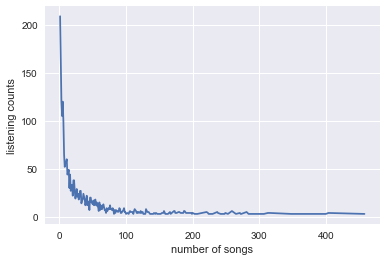

In [126]:
plt.plot(filtered_count_freq['frequency'], filtered_count_freq['count'])
plt.xlabel('number of songs')
plt.ylabel('listening counts')
plt.show()

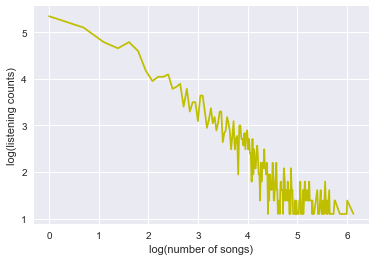

In [132]:
plt.plot(np.log(filtered_count_freq['frequency']), np.log(filtered_count_freq['count']), 'y')
plt.xlabel('log(number of songs)')
plt.ylabel('log(listening counts)')
plt.show()

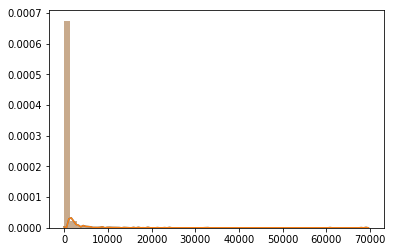

In [106]:
sns.distplot(filtered_SONG_COUNT.values)
plt.show()

In [86]:
# Encode user and song id to make integer position 
track_encoder = preprocessing.LabelEncoder()
train['TRACK_ID'] = track_encoder.fit_transform(train['track_id'])
user_encoder = preprocessing.LabelEncoder()
train['USER_ID'] = user_encoder.fit_transform(train['user'])

/anaconda3/envs/si618/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/envs/si618/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [89]:
train.track_id.unique().shape[0] # train: 3612, test: 2979, 2916 common track_id, 3675 union

3612

In [91]:
# Check for common track id and cold start
#test_track_set = pd.DataFrame(test.track_id.unique())
#train_track_set = pd.DataFrame(train.track_id.unique())
test_track_set.merge(train_track_set, how='outer').shape 

(3675, 1)

In [55]:
# Create matrix
listening_counts = np.array(train['count'].values)
user_pos = np.array(train['USER_ID'].values)
song_pos = np.array(train['TRACK_ID'].values)
mtx = sparse.coo_matrix((listening_counts, (user_pos,song_pos)), shape=(334601, 3607))
user_song_matrix = mtx.tocsr() #(334601, 3607)

In [ ]:
def predict_CF(data):
    for index, row in data.iterrows():
        try:
            u_ind = filtered_USER_AVG[row['user']]
        except:
            continue
        try:
            m_ind = filtered_SONG_AVG[row['track_id']]
        except:
            continue
        
        users_position = 